<a href="https://colab.research.google.com/github/daripp/XCT_FCN/blob/main/For_publication_Leaf_ALS_FCN_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Welcome to the Training and Inference Pipeline ***

# ***Step 1: Mount google drive***

# ***Input code from google to access your drive***

*** Consider running your instance locally. This will require modification of the file name paths, but will allow use on computers with more resources.***

### *To run a local instance:*

jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8080  --NotebookApp.port_retries=0

Code by Pranav Raja, Devin Rippner, and Alexander Buchko

In [1]:
#Code Box 1
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'01a Intro Env Soil Chem  and Soil Minerals_Jan9.pdf'
'01b Soil Minerals_Jan11.pdf'
'01c Soil Minerals_Jan13.pdf'
'01e Soil Minerals_Jan20.pdf'
 01f_Applied_Minerals_Rippner.pdf
'02a organic matter_Jan23.pdf'
'02b organic matter_Jan25.pdf'
'02c organic matter_Jan27.pdf'
'02d organic matter_Jan30.pdf'
'03b Soil solution_Feb6.pdf'
'03c Soil solution_Feb8.pdf'
'03d Soil solution_Feb10.pdf'
'03e Soil solution_Feb13.pdf'
'04a Sorption_Feb15.pdf'
'04c Sorption_Feb22.pdf'
'04d Sorption_Feb24.pdf'
'04e Sorption_Feb27.pdf'
'04g Sorption_March3.pdf'
'05b redox_March10.pdf'
'05c redox_March13.pdf'
'05d redox_March15.pdf'
'06 Arsenic Lecture_march 17.pdf'
 13_Mar_12-15_Grades-SSC_202_001_WQ_2017.gsheet
'142500 Tube A  Almond Buds0017.tif'
'15N figures 16NOV17.pptx'
 20161114_201004.mp4
'2017 Review Questions - 1.pdf'
'2017 Review Questions 3-key.pdf'
'2017 Review Questio

In [2]:
!nvidia-smi
!pip freeze>>requirements.txt

Tue Feb  1 00:34:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#**Materials**
  Input the material mask name and information below.

  Specifically:
 
  **name** - The name for the material. This is pretty arbitrary, but it will be
  used to label output folders and images.
 
  **input_rbg_vals** - The rbg values of the material in the input mask image.
 
  **output_val** - The greyscale value of the mask when you output the images.
  This is arbitrary, but every material should have its own output color
  so they can be differentiated
 
  **confidence_threshold** - The lower this number, the more voxels will be labled a specific material. Essentially, the ML algorith outptus a confdience value  (centered on 0.5) for every voxel and every material. By default, voxels with  a confidence of 0.5 or greater are determined to be the material in question.  But we can labled voxles with a lower condience level by changing this  parameter
  
  **training_image_directory /training_mask_directory**: Input the directory where your training images and masks are located.

  **validation_fraction**: Input the fraction of images you want to validate your model during training. These are not a independent validation, but are part of the training process.

  **num_models**: Enter the number of models you want to iteratively train. Because these are statistical models, the performance of any given model will vary. Training more models will allow you to select the model that best fits your data.
  
  **num_epochs**: Enter number of epochs that you want to use to train your model. More is generally better, but takes more time.

  **batch_size**: Input your batch size. Larger batch sizes allow for faster training, but take up more VRAM. If you are running out of VRAM during training, decrease your batch size.

  **scale**: Input how you want your images scaled during model training and inference. When the scale is 1, your images will be used at full size for training. When the scale is less than 1, your images will be downsized according to the scale you set for training and inference, decreasing VRAM usage. If you run out of VRAM during training, consider rescaling your images.

  **models_directory**: Directory where your models are saved.

  **model_group**: Name for the group models you iteratively generate.

  **current_model_name**: Name for each individual model you generate; will automatically be labeled 1 through n for the number of models you specify above.

  **val_images/val_masks**: Input the directory where your independent validation images and masks are located. These images are not used for training and are used as an independent validation of your model.

  **csv_directory**: Directory where a CSV file of your validation results will be saved.

  **inference_directory**: Directory where the images you want analyzed are located.

  **output_directory**: Directory where you want your analysis results to be saved.



In [4]:
#Code Box 2
class Material:
 
  def __init__(self, name, input_rgb_vals, output_val, confidence_threshold=0):
    self.name = name
    self.input_rgb_vals = input_rgb_vals
    self.output_val = output_val
    self.confidence_threshold = confidence_threshold
 
#Creating a list of materials so we can iterate through it
materials = [
             Material("background", [85,85,85], 30, 0.5),
             Material("epidermis", [170,170,170], 150, 0.5),
             Material("mesophyll", [255,255,255], 255, 0.5),
             Material("air_space", [0,0,0], 1, 0.4),
             Material("bundle_sheath_extension", [103,103,103], 100, 0.5),
             Material('vein', (35,35,35), 180, 0.5)
            ]
 
num_materials =len(materials)
#Various input/output directories
training_image_directory = "drive/MyDrive/ALS Workflow/train/leaf_images/"
training_mask_directory = "drive/MyDrive/ALS Workflow/train/leaf_masks/"
#Fraction of total annotations you want to leave for validating the model.
validation_fraction=0.2
#Model Performance varies, make multiple models to have the best chance at success.
num_models=10
#Model Performance improves with increasing epochs, to a point.
num_epochs=100
"""Increasing batch size increase model training speed, but also eats up VRAM on the GPU. Find a balance between scale and batch size
that best suits your needs"""
batch_size=1
#Decrease scale to decrease VRAM usage; if you run out of VRAM during traing, restart your runtime and down scale your images
scale=1
#Save batch normalization:

#Input model directory
models_directory = "drive/MyDrive/ALS Workflow/best_models/"
#Input the name you want to use for your group of models
model_group='10 leaf bce p2 100 epoch/'
current_model_name = '10 leaf bce p2 100 epoch__'
"""Hold images/annotations in reserve to test your model performance. Use this metric to decide which model you want to use 
for your data analysis"""
test_images = "drive/MyDrive/ALS Workflow/test/test_images/"
test_masks= 'drive/MyDrive/ALS Workflow/test/test_masks/'
csv_directory = "drive/MyDrive/ALS Workflow/10 leaf bce p2 100 epoch testing code change.csv"
#Input the directory of the data you want to segment here.
inference_directory= "drive/MyDrive/ALS Workflow/test/test_images/"
#Input the 5 alpha-numeric characters proceding the file number of your images
  #EX. Jmic3111_S0_GRID image_0.tif ----->mage_
proceeding="lice_"
#Input the 4 or mor alpha-numeric characters following the file number
  #EX. Jmic3111_S0_GRID image_0.tif ----->.tif
following=".png"
output_directory = "drive/MyDrive/ALS Workflow/test_images_results change/"

#**Parameter Loading**
Please do not alter this code

In [8]:
#Code Box 3
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
import random
#import scipy.ndimage as ndi
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy.ndimage import morphology
from torch.utils.data import DataLoader, random_split

import pandas as pd
 
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=scale, transform=False):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.transform=transform
        self.t_list=A.Compose([A.HorizontalFlip(p=0.4),A.VerticalFlip(p=0.4), A.Rotate(limit=(-50, 50), p=0.4),])
        self.means=[0,0,0]
        self.stds=[1,1,1]

        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
 
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')
 
    def __len__(self):
        return len(self.ids)
 
 
    @classmethod
    def mask_preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
 
        img_nd = np.array(pil_img)
 
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
 
       
        return img_nd
    
 
        
    def img_preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
 
        img_nd = np.array(pil_img)
 
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
 
       
 
        return img_nd
 
    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + '*')
        img_file = glob(self.imgs_dir + idx + '*')
 
        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])
 
  
        
 
        
        #Reshapes from 1 channel to 3 channels in grayscale
        img = self.img_preprocess(img, self.scale)
        mask = self.mask_preprocess(mask, self.scale)
        new_image=np.zeros((img.shape[0],img.shape[1],3))
        new_image[:,:,0]=img[:,:,0]
        new_image[:,:,1]=img[:,:,0]
        new_image[:,:,2]=img[:,:,0]
        
 
 
 
        img=new_image
 
        #New Code
        masklist=[]
            
        for i, mat in enumerate(materials):
        
          indices = np.all(mask == mat.input_rgb_vals, axis=-1)
          new_mask=np.zeros((img.shape[0],img.shape[1]))
          new_mask[indices] = 1
          masklist.append(new_mask)
 
        mask=masklist
  
 
        
        if img.max() > 1:
            img = img / 255
 
       
 
        
        if self.transform:
            augmented=self.t_list(image=img, masks=mask)
            img=augmented["image"]
            mask=augmented["masks"]
            
 
        
 
        img = img.transpose((2, 0, 1))
        
        mask=np.array(mask)
        
        
 
        
 
        img=torch.from_numpy(img)
        mask=torch.from_numpy(mask)
        
        img=transforms.Normalize(mean=self.means, std=self.stds)(img)
        return img, mask
        
        
dataset = BasicDataset(training_image_directory, training_mask_directory, scale=scale, transform=False)
 
#!!!!!!!!!!!!!!!!!!!!!!!!!!Set batch size here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

nimages = 0
mean = 0. 
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)
 
# Final step
mean /= nimages
std /= nimages
 
print(mean)
print(std)

dataset.means=mean
dataset.stds=std 

nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)
 
# Final step
mean /= nimages
std /= nimages
 
print(mean)
print(std)


tensor([0.4742, 0.4742, 0.4742], dtype=torch.float64)
tensor([0.0569, 0.0569, 0.0569], dtype=torch.float64)
tensor([-3.4613e-16, -3.4613e-16, -3.4613e-16], dtype=torch.float64)
tensor([1.0000, 1.0000, 1.0000], dtype=torch.float64)


Now you are ready to train your model in code block 4. 
If you run out of VRAM, restart the runtime, reload google drive, and try again. Also consider rescaling your images or decreasing your batch size.


#**Model** **Training**
Please do not alter this code.

In [ ]:
#For loop for FCN model training Cell Code Box 4
#!cd "drive/My Drive/Colab Notebooks"
# Semantic Segmentation and Data Extraction in Pytorch Using FCN by Pranav Raja
 
import torchvision
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch.utils.data import DataLoader, random_split
import torch
# from torch._six import container_abcs, string_classes, int_classes
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import psutil
import gc
import random
 
dir_checkpoint = models_directory
 
 
model_group=model_group
num_models=num_models
os.mkdir(dir_checkpoint+model_group)
seed=0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
for i in range(num_models):
  #!!!!!!! Here we pull in a pretrained FCN on torch and we replace the output layer since we have six classes rather than 21!!!!!!!!
  num_classes=num_materials
  model=torchvision.models.segmentation.fcn_resnet101(pretrained=True, progress=True)
  model.classifier=FCNHead(2048, num_classes)
  
  def trainval_split(dataset, val_fraction=0.5):
 
    validation_size = int(len(dataset) * val_fraction)
    train_size = len(dataset) - validation_size
    train, val = torch.utils.data.random_split(dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(i))
 
    return train, val
 
 
 
  dataset= BasicDataset(training_image_directory, training_mask_directory, scale=scale, transform=True)
  dataset_train, dataset_val=trainval_split(dataset, val_fraction=validation_fraction)

  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)#, collate_fn=pad_collate)
  val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)#, collate_fn=pad_collate)
 
 
  #%%
 
  # this is the train code 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  #!!!!!!!!!!!!!!!!!!!!!!!!!!!! Input epochs here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  num_epochs=num_epochs
  # read up on optimizers but Adam should work for now, if you get good results with Adam then you can try SGD (it's harder to tune but usually converges better)
  optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
 
  #just initializing a value called best_loss
  best_loss=999
 
  # choose a loss function

  criterion = nn.BCEWithLogitsLoss()

  #this is the train loop
  for epoch in range(num_epochs):
      print(psutil.virtual_memory().percent)
      print('Epoch: ', str(epoch))
    #add back if doing fractional training
      train_loader.dataset.dataset.transform=True
      model.train()
      for images, masks in train_loader:
 
          images = images.to(device=device, dtype=torch.float32)
          masks = masks.to(device=device, dtype=torch.float32)
 
          #forward pass
          preds=model(images)['out'].cuda()
        
          #compute loss
          loss=criterion(preds, masks)
        
          #reset the optimizer gradients to 0
          optimizer.zero_grad()
 
          #backward pass (compute gradients)
          loss.backward()
 
          #use the computed gradients to update model weights
          optimizer.step()
 
          print('Train loss: '+str(loss.to('cpu').detach()))
      # model.eval()
      #add back if doing fractional training
      val_loader.dataset.dataset.transform=False
      current_loss=0
      
      #test on val set and save the best checkpoint
      model.eval()
      with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device=device, dtype=torch.float32)
            masks = masks.to(device=device, dtype=torch.float32)
            preds=model(images)['out'].cuda()
            # print(preds)
            # print(masks)
            loss=criterion(preds, masks)
            #print('hi')
            current_loss+=loss.to('cpu').detach()
            del images, masks, preds, loss
  #!!!!!!!!!!!!!!!!!!!!!!!!!!!Re-name model here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!        
      if best_loss>current_loss:
          best_loss=current_loss
          print('Best Model Saved!, loss: '+ str(best_loss))
          torch.save(model.state_dict(), dir_checkpoint+model_group + current_model_name+str(i+1)+".pth")
      else:
          print('Model is bad!, Current loss: '+ str(current_loss) + ' Best loss: '+str(best_loss))
      print('\n')

# **Validation**
Please do not alter this code

In [ ]:
import torch.nn as nn
import torchvision
import torch
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch.utils.data import DataLoader, random_split
#from statistics import mean
import numpy as np
import pandas as pd
# interim_list=[]
modeldata = pd.DataFrame(columns=["name", "precision", "recall", "accuracy", "f1"])

 
for s in range(num_models):

 
 
  model=torchvision.models.segmentation.fcn_resnet101(pretrained=False)
  #!!!!!!!!!!!!!!!!!Specify Layer # here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  model.classifier=FCNHead(2048, num_materials)
  device = torch.device('cuda')
 
  outputs=[]
  model.to(device)
 
  #!!!!!!!!!!!!!!!!!!!!!Select Correct Model from the best models directory!!!!!!!!!!!!!!!!!!!!!!!!!1
 
  model.load_state_dict(torch.load(models_directory+model_group + current_model_name+str(s+1)+".pth"), strict=False)
 
 
  model.train()
 
  dataset_val = BasicDataset(test_images, test_masks, scale=scale, transform=False)
  val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)#, collate_fn=pad_collate)
 
  prop_list = []
  for mat in materials:
    prop_list.append([[],[],[],[]])
 
  for images, target in val_loader:
    images = images.to(device=device, dtype=torch.float32)
    target = target.to(device=device, dtype=torch.float32)
 
    with torch.no_grad():
      pred=model(images)['out'].cuda()
      pred=nn.Sigmoid()(pred)
    
    for i, mat in enumerate(materials):
      material_target=target[:,i,:,:]
      material_pred = pred[:, i, :, :]
      material_pred[material_pred >=mat.confidence_threshold] = 1
      material_pred[material_pred <=mat.confidence_threshold] = 0
      pred[:, i, :, :]=material_pred
 
      material_tp=torch.sum(material_target*material_pred, (1,2))
      material_fp=torch.sum((1-material_target)*material_pred, (1,2))
      material_fn=torch.sum(material_target*(1-material_pred), (1,2))
      material_tn=torch.sum((1-material_target)*(1-material_pred), (1,2))
 
     
 
      material_precision=torch.mean(material_tp/(material_tp+material_fp))
      material_recall=torch.mean(material_tp/(material_tp+material_fn))
      material_accuracy=torch.mean((material_tp+material_tn)/(material_tp+material_tn+material_fp+material_fn))
      material_f1=torch.mean((material_tp)/(material_tp+0.5*(material_fp+material_fn)))
 
    
      prop_list[i][0].append(material_precision.cpu().detach().numpy())
      prop_list[i][1].append(material_recall.cpu().detach().numpy())
      prop_list[i][2].append(material_accuracy.cpu().detach().numpy())
      prop_list[i][3].append(material_f1.cpu().detach().numpy())
 
          
 
 
 
 
  model_name=current_model_name
  model_number=(str(s+1))
  print(model_name)
 
  #printing with pandas
  properties = {"name" : [mat.name for mat in materials],
                "precision" : [str(np.mean(prop_list[i][0])) for i in range(num_materials)],
                "recall" : [str(np.mean(prop_list[i][1])) for i in range(num_materials)],
                "accuracy" : [str(np.mean(prop_list[i][2])) for i in range(num_materials)],
                "f1" : [str(np.mean(prop_list[i][3])) for i in range(num_materials)]}
  df = pd.DataFrame(properties, columns = ["name", "precision", "recall", "accuracy", "f1"])
  df=pd.concat([df, pd.DataFrame(columns=["model number","model name"])])
  df[["model number","model name"]]=[model_number, model_name]
  # display(df)
  
  modeldata=modeldata.append([df], ignore_index=True)


display(modeldata)



#**Save Validation CSV**
Please do not alter this code

In [ ]:
display(modeldata)
modeldata.to_csv(csv_directory)

#**Load Model**
**model_number**: Select the best model number above and input into the model_number line. Dont forget the quotation marks.

In [ ]:
"""Input model number here"""
model_number='8'

#Run

In [ ]:
#Code Box 5
import torch
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as T
import numpy as np
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
 
 
import time




 
model=torchvision.models.segmentation.fcn_resnet101(pretrained=False)

model.classifier=FCNHead(2048, num_materials)
 
device = torch.device('cuda')
 
outputs=[]
model.to(device)
 
#!!!!!!!!!!!!!!!!!!!!!Select Correct Model from the best models directory!!!!!!!!!!!!!!!!!!!!!!!!!1
model.load_state_dict(torch.load(models_directory+model_group + current_model_name+model_number+'.pth'), strict=False)
 
 
 
 
model.train()

#**Image Segmentation and Data Extraction**

In [ ]:
#Use this block for data extraction using the regionprops function at the bottom of this code, good for area/perimeter, counting.
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
!ls "/content/drive/My Drive"


import os
import pandas as pd
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import argparse
import torch
import torchvision
from PIL import Image

from glob import glob
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from scipy.ndimage import morphology
sys.path.append(os.path.join(sys.path[0]))  # To find local version of the library

from torchvision.models.detection.rpn import AnchorGenerator
import torch
from skimage.color import rgb2grey, label2rgb



from skimage import io,exposure, feature, filters, io, measure, morphology, restoration, segmentation, transform, util, data, color
from skimage.measure import label, regionprops
from skimage.transform import rescale, resize, downscale_local_mean
import os
import numpy as np


#!!!!!!!!!!!!!!!!!!!!!Put the name of the folder with the images you want to analyze here!!!!!!!!!!!!!!!!!!!!!!!
#dir_name = inference_directory
dir_name=test_images

filenames = os.listdir(dir_name)


whole_leaf_tables=[]
file_name=[]
color=[]
value_counts=[]
sort_idx = np.argsort([(int(filename.split(proceeding)[1].split(following)[0])) for filename in filenames])
# sort_idx = np.argsort([(int(filename.split('.')[0])) for filename in filenames])
for i in sort_idx:
    #makes new directory called "(directory name here) + name in red" that your new images go into
    new_dir_name = output_directory
    if not os.path.exists(new_dir_name):
      os.makedirs(new_dir_name)
    
    for mat in materials:
      new_dir_name_mat= new_dir_name + mat.name
      if not os.path.exists(new_dir_name_mat):
        os.makedirs(new_dir_name_mat)
    filename = filenames[i]
    
    image = Image.open(dir_name +'/'+ filenames[i])
    image1 = (image)
    image1 = np.array(image1)
    
    w, h = image.size
    print(image.size)
    #!!!!!!!!!!!!!!!!!!!!Make sure scale matches!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    scale=scale
    newW, newH = int(scale * w), int(scale * h)
    image=image.resize((newW, newH))
    image=np.array(image)
    new_im=np.zeros((3, newH, newW))
    new_im[0,:,:]=image
    new_im[1,:,:]=image
    new_im[2,:,:]=image
    image=new_im
    

    image=torch.from_numpy(image)

#!!!!!!!!!!!!!!!!!!!!!!!!!!Make sure normalization goes match above!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    image=T.Normalize(mean=mean, std=std)(image)
 
    image.unsqueeze_(0)
    image = image.to(device=device, dtype=torch.float32)


    tic=time.time()
    with torch.no_grad():
      mask=model(image)['out']
      mask=nn.Sigmoid()(mask)
      # mask=mask.cpu().detach().numpy()
    toc=time.time()
    print('time: '+str(toc-tic))
#!!!!!!!!!!!!!!!!!Make sure there are the same number of mask outputs as you trained on!!!!!!!!!!!!!!!!!!!!!
    image_rescaled = rescale(image1, scale, anti_aliasing=True)
    combined_image = image_rescaled = rescale(image1, scale, anti_aliasing=True)
    list_of_mat_tables = []
    for i, mat in enumerate(materials):
      mat_mask = mask.cpu().detach().numpy()[0,i,:,:]
      mat_mask[mat_mask >= mat.confidence_threshold] = mat.output_val
      mat_mask[mat_mask < mat.confidence_threshold] = 0

      combined_image = np.add(combined_image, mat_mask, casting="unsafe")
      img3=label2rgb(combined_image, image_rescaled, alpha=0.2)  
      io.imsave(new_dir_name+'/' + mat.name + '/'+filename.split(following)[0]+'_' + mat.name + "_mask.png", mat_mask)
      np_mat = np.array(mat_mask)

      
      label_mat = label(np_mat, background = 0)
      if np.sum(label_mat)<1:
        label_mat=np.ones_like(label_mat)
      elif np.sum(label_mat)>=1:
        label_mat=label_mat

      
      mat_table=measure.regionprops_table(label_mat, combined_image, properties=['label','area','perimeter'])
      mat_table=pd.DataFrame(mat_table)
      if mat_table['area'].sum()==np.ones_like(label_mat).sum():
        mat_table_a=mat_table['area'].sum()==0
      
      elif mat_table['area'].sum()<np.ones_like(label_mat).sum():
        mat_table_a=mat_table['area'].sum()/(scale**2)

      if mat_table['area'].sum()==np.ones_like(label_mat).sum():
        mat_table_p=mat_table['perimeter'].sum()==0
     
      elif mat_table['area'].sum()<np.ones_like(label_mat).sum():
        mat_table_p=mat_table['perimeter'].sum()/(scale)



      # mat_table_a=mat_table['area'].sum()
      # mat_table_p=mat_table['perimeter'].sum()

      list_of_mat_tables.append(mat_table_a)
      list_of_mat_tables.append(mat_table_p)
      

    io.imsave(new_dir_name+'/'+filename.split(following)[0]+'.png', combined_image)    

    print(list_of_mat_tables)
    list_of_mat_tables = np.array(list_of_mat_tables, dtype=int)
    whole_leaf = value_counts.append(list_of_mat_tables)
    print(whole_leaf)

    name = file_name.append([filename])
  
counts=(np.array(value_counts))
print(counts)
names=(np.array(file_name))
print(names)

whole_leaf=np.concatenate((names, counts), axis=1)

whole_leaf_table=(pd.DataFrame(whole_leaf))
print(whole_leaf_table)
table_columns = [[f"{mat.name} area(pix)", f"{mat.name} perimeter (pix)"] for mat in materials]
print(table_columns)
table_columns = [element for sublist in table_columns for element in sublist] #flattening the list
print(table_columns)
table_columns = ["file_name"] + table_columns
print(table_columns)
whole_leaf_table.columns = table_columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row',None)
# print(d)
#!!!!!!!!!!!!!!!!!!!!!!!!!!Can change table output name here!!!!!!!!!!!!!!!!!!!!!!!!!!
whole_leaf_table.to_csv(new_dir_name+'/'+'material area and perimeter.csv')
#print (counts)
print('----end-----')

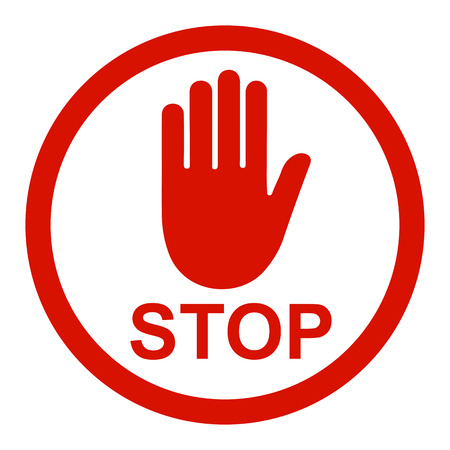